0) Environment & Imports

In [2]:

# 0) Clean out likely offenders that require NumPy 2.x
!pip -q uninstall -y opencv-python opencv-python-headless jax jaxlib \
  tensorflow_decision_forests tf-keras torch torchvision torchaudio onnxruntime || true

# 1) Force-reinstall a consistent stack (TF 2.16 works with NumPy 1.26.x)
!pip -q install --no-cache-dir --upgrade --force-reinstall \
  numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.5.2 \
  tensorflow==2.16.1 keras==3.3.3 protobuf==4.25.3 \
  streamlit==1.37.0 altair==5.3.0 opencv-python==4.9.0.80

# 2) IMPORTANT: restart runtime (Kernel) once after the installs, then run the cell below.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 226.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 244.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 249.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 199.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 MB 193.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 313.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 185.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 354.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 167.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy as np, pandas as pd, sklearn, tensorflow as tf, cv2
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
print("TF:", tf.__version__)
print("OpenCV:", cv2.__version__)


NumPy: 1.26.4
Pandas: 2.2.2
sklearn: 1.5.2
TF: 2.16.1
OpenCV: 4.9.0


In [2]:
import os, json, math, threading, time, textwrap, subprocess, sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option("display.max_columns", 120)
print("TF:", tf.__version__)


TF: 2.16.1


1) Load 20% data

In [3]:
CSV_PATH = "/content/df_subset_20.csv"   # <- change if needed
df = pd.read_csv(CSV_PATH)
df.head(3)


,title,stars,reviews,price,category,isBestSeller,boughtInLastMonth,category_encoded,title_clean
0,"Power Tool Organizer Shelf, Heavy Duty Drill H...",0.92,0.000307,0.001296,Home Storage Organization,0,0.0025,118,"power tool organizer shelf, heavy duty drill h..."
1,"Disney Girls Baseball Cap, Frozen Elsa & Anna ...",0.94,0.000379,0.001198,Sporting Apparel,0,0.0000,225,"disney girls baseball cap, frozen elsa & anna ..."
2,Micro OTG Card Reader High-Speed USB Universal...,0.00,0.000000,0.000000,Memory Card Accessories,0,0.0000,163,micro otg card reader high-speed usb universal...


2) Basic cleaning & target prep

Assumptions (rename if your columns differ):

price (float), bestseller (bool/0-1/Yes-No)

boughtInLastMonth (int/float)

reviews, stars, category, brand, etc.

In [5]:
# ---- 0) Inspect columns quickly (optional)
print(sorted(df.columns.tolist())[:60])

# ---- 1) Helper to find a column by common aliases (case/space-insensitive)
def find_col(cands):
    cols = {c.lower().replace(" ", "").replace("-", "").replace("_",""): c for c in df.columns}
    for alias in cands:
        k = alias.lower().replace(" ", "").replace("-", "").replace("_","")
        if k in cols:
            return cols[k]
    return None

# Try to locate a "bestseller" boolean-ish column by aliases
bestseller_col = find_col([
    "bestseller","best_seller","is_bestseller","isbestseller","bestSeller",
    "isBestSeller","best_seller_flag","bestsellerflag","bestseller_y_n"
])

# If not found, try to derive one. Example heuristics (pick one that fits your data):
#   A) if there's a 'badge' or 'labels' column containing the phrase 'best seller'
badge_col = find_col(["badge","badges","label","labels","tags"])
if bestseller_col is None and badge_col is not None:
    df["_bestseller_tmp"] = df[badge_col].astype(str).str.lower().str.contains("best seller|bestseller")
    bestseller_col = "_bestseller_tmp"

#   B) else: derive from recent sales (top 20% of boughtInLastMonth -> 1)
bilm_col = find_col(["boughtinlastmonth","bought_last_month","monthly_sales","lastmonthsales"])
if bestseller_col is None and bilm_col is not None:
    thr = df[bilm_col].astype("float64").quantile(0.80)
    df["_bestseller_tmp2"] = (pd.to_numeric(df[bilm_col], errors="coerce").fillna(0) >= thr)
    bestseller_col = "_bestseller_tmp2"

#   C) else: fall back to 0s (safe default)
if bestseller_col is None:
    df["_bestseller_fallback"] = 0
    bestseller_col = "_bestseller_fallback"

# ---- 2) Normalize bestseller → {0,1}
def to_bool(x):
    if isinstance(x, str):
        x = x.strip().lower()
        if x in ("yes","true","y","t","1","bestseller","best seller"):
            return 1
        if x in ("no","false","n","f","0","not bestseller","non-bestseller"):
            return 0
    if isinstance(x,(int,np.integer,bool,np.bool_)):
        return int(x)
    return 0

df["bestseller"] = df[bestseller_col].apply(to_bool).astype(int)

# ---- 3) Numeric core columns: coerce → fill → clip
for col in ["price","boughtInLastMonth","reviews","stars"]:
    c = find_col([col])  # allow small naming differences
    if c is None:
        continue
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df[c].fillna(df[c].median())

# Optional clip for price
price_col = find_col(["price","unitprice","listprice","saleprice"])
if price_col:
    p995 = df[price_col].quantile(0.995)
    df[price_col] = np.clip(df[price_col], 0, p995)

# ---- 4) Categories
category_col = find_col(["category","productcategory","cat"])
brand_col    = find_col(["brand","manufacturer","maker"])

for c in [category_col, brand_col]:
    if c:
        df[c] = df[c].astype(str).fillna("Unknown").replace({"nan":"Unknown"})

# ---- 5) Feature/target selection (only use existing columns)
target_price = price_col or "price"
target_best  = "bestseller"

num_feats = [c for c in [find_col(["reviews"]), find_col(["stars"]), find_col(["boughtInLastMonth"])] if c]
cat_feats = [c for c in [category_col, brand_col] if c]
features  = num_feats + cat_feats

# Keep rows where we have targets
keep_cols = [c for c in [target_price, target_best] if c in df.columns]
df = df.dropna(subset=keep_cols)

# Final X/y
X = df[features].copy()
y_price = df[target_price].astype(float).values
y_best  = df[target_best].astype(int).values

print("Rows:", len(df))
print("Features:", features)
print("Numeric:", num_feats, "Categorical:", cat_feats)


['boughtInLastMonth', 'category', 'category_encoded', 'isBestSeller', 'price', 'reviews', 'stars', 'title', 'title_clean']
Rows: 533295
Features: ['reviews', 'stars', 'boughtInLastMonth', 'category']
Numeric: ['reviews', 'stars', 'boughtInLastMonth'] Categorical: ['category']


3) Preprocess (One-Hot + Scale) and split

In [7]:
import numpy as np, sklearn
from packaging import version
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# version-safe kwargs for OneHotEncoder
ohe_kwargs = dict(handle_unknown="ignore", min_frequency=10, dtype=np.float32)
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs["sparse_output"] = False     # new name
else:
    ohe_kwargs["sparse"] = False            # old name

transformers = []
if len(num_feats) > 0:
    transformers.append(("num", StandardScaler(), num_feats))
if len(cat_feats) > 0:
    transformers.append(("cat", OneHotEncoder(**ohe_kwargs), cat_feats))

# If no features were found, raise a helpful error
if not transformers:
    raise ValueError("No features to transform. Check num_feats/cat_feats.")

ct = ColumnTransformer(transformers=transformers, remainder="drop")

# Fit on train, transform train/test
Xtr = ct.fit_transform(X_train)
Xte = ct.transform(X_test)

Xtr.shape, Xte.shape


((426636, 269), (106659, 269))

4) Build the MTL-FFNN (shared trunk + 2 heads)

In [8]:
input_dim = Xtr.shape[1]
inputs = keras.Input(shape=(input_dim,), name="features")

# Shared trunk
h = layers.Dense(256, activation="relu")(inputs)
h = layers.Dropout(0.2)(h)
h = layers.Dense(128, activation="relu")(h)
h = layers.Dropout(0.1)(h)

# Heads
price_out = layers.Dense(1, name="price_out")(h)                     # regression
best_out  = layers.Dense(1, activation="sigmoid", name="best_out")(h)  # binary prob

model = keras.Model(inputs=inputs, outputs=[price_out, best_out], name="mtl_ffnn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss={"price_out": "mse", "best_out": "binary_crossentropy"},
    loss_weights={"price_out": 1.0, "best_out": 0.7},  # tweakable
    metrics={"price_out": [], "best_out": ["accuracy"]}
)

model.summary()


Model: "mtl_ffnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 269)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     69,120 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_out (Dense)   │ (None, 1)         │        129 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ best_out (Dense)    │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,274 (399.51 KB)

 Trainable params: 102,274 (399.51 KB)

 Non-trainable params: 0 (0.00 B)

5) Train

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

history = model.fit(
    Xtr, {"price_out": ytr_p, "best_out": ytr_b},
    validation_split=0.2,
    epochs=50, batch_size=512,
    callbacks=callbacks, verbose=1
)

pd.DataFrame(history.history).tail(3)


Epoch 1/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - best_out_accuracy: 0.9806 - loss: 0.0773 - val_best_out_accuracy: 0.9936 - val_loss: 0.0190
Epoch 2/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - best_out_accuracy: 0.9937 - loss: 0.0185 - val_best_out_accuracy: 0.9935 - val_loss: 0.0192
Epoch 3/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - best_out_accuracy: 0.9939 - loss: 0.0180 - val_best_out_accuracy: 0.9936 - val_loss: 0.0189
Epoch 4/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - best_out_accuracy: 0.9939 - loss: 0.0175 - val_best_out_accuracy: 0.9935 - val_loss: 0.0191
Epoch 5/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - best_out_accuracy: 0.9939 - loss: 0.0172 - val_best_out_accuracy: 0.9936 - val_loss: 0.0192
Epoch 6/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - best_out_accuracy: 0.9940 - loss: 0.0166 - val_best_out_accuracy: 0.9935 - val_loss: 0.0190
Epoch 7/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - best_out_accuracy: 0.9940 - loss: 0.0170 - val_best_out_accu

,best_out_accuracy,loss,val_best_out_accuracy,val_loss
5,0.993915,0.017038,0.993543,0.018951
6,0.993903,0.016930,0.993578,0.019827
7,0.993906,0.016896,0.993578,0.019245


6) Evaluate (R², RMSE, MAE + Accuracy/F1)

In [10]:
# Predictions
pred_p, pred_b_prob = model.predict(Xte, verbose=0)
pred_p = pred_p.reshape(-1)
pred_b = (pred_b_prob.reshape(-1) >= 0.5).astype(int)

# Regression metrics
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

r2_score = r2(yte_p, pred_p)
rmse = mean_squared_error(yte_p, pred_p, squared=False)
mae  = mean_absolute_error(yte_p, pred_p)

# Classification metrics
acc = accuracy_score(yte_b, pred_b)
f1  = f1_score(yte_b, pred_b, zero_division=0)

print(f"Regression: R2={r2_score:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")
print(f"Classification: ACC={acc:.3f} | F1={f1:.3f}")
print("\nClassification report:\n", classification_report(yte_b, pred_b, zero_division=0))


Regression: R2=0.301 | RMSE=0.005 | MAE=0.002
Classification: ACC=0.994 | F1=0.022

Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    106023
           1       0.64      0.01      0.02       636

    accuracy                           0.99    106659
   macro avg       0.82      0.51      0.51    106659
weighted avg       0.99      0.99      0.99    106659



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7) Compute KPIs (Actual vs Predicted) for 20% subset

Your KPIs:

Average Price by Category

Average Monthly Sales (boughtInLastMonth)

Bestseller Ratio (%) per Category

For KPI on predicted values:

Use predicted price (continuous) per category

Use predicted bestseller (0/1) per category

Monthly sales is not predicted by the model; we report actual for 20% EDA (still useful and required by Jorge). If later you add demand prediction, you can compute predicted KPI too.

In [11]:
# Build a results DataFrame on TEST set to compare actual vs predicted KPIs
test_df = X_test.copy()
test_df['actual_price'] = yte_p
test_df['pred_price']   = pred_p
test_df['actual_best']  = yte_b
test_df['pred_best']    = pred_b

# KPI 1: Average Price by Category (actual vs predicted)
kpi1_actual = test_df.groupby('category')['actual_price'].mean().rename("avg_price_actual")
kpi1_pred   = test_df.groupby('category')['pred_price'].mean().rename("avg_price_pred")
kpi1 = pd.concat([kpi1_actual, kpi1_pred], axis=1).sort_values('avg_price_actual', ascending=False)

# KPI 2: Average Monthly Sales by Category (actual only for 20% stage)
if 'boughtInLastMonth' in X_test.columns:
    tmp = X_test.copy()
    tmp['boughtInLastMonth'] = pd.to_numeric(tmp['boughtInLastMonth'], errors='coerce').fillna(0)
    kpi2 = tmp.groupby('category')['boughtInLastMonth'].mean().rename("avg_monthly_sales")
else:
    kpi2 = pd.Series(dtype=float, name="avg_monthly_sales")

# KPI 3: Bestseller Ratio % per Category (actual vs predicted)
kpi3_actual = (test_df.groupby('category')['actual_best'].mean()*100).rename("bestseller_ratio_actual_%")
kpi3_pred   = (test_df.groupby('category')['pred_best'].mean()*100).rename("bestseller_ratio_pred_%")
kpi3 = pd.concat([kpi3_actual, kpi3_pred], axis=1).sort_values('bestseller_ratio_actual_%', ascending=False)

# Save artifacts for the Streamlit app
os.makedirs("/content/artifacts_20", exist_ok=True)
kpi1.to_csv("/content/artifacts_20/kpi_avg_price_by_category.csv")
kpi2.to_csv("/content/artifacts_20/kpi_avg_monthly_sales_by_category.csv")
kpi3.to_csv("/content/artifacts_20/kpi_bestseller_ratio_by_category.csv")

metrics = {
    "R2": float(r2_score), "RMSE": float(rmse), "MAE": float(mae),
    "ACC": float(acc), "F1": float(f1)
}
with open("/content/artifacts_20/metrics.json","w") as f:
    json.dump(metrics, f, indent=2)

print("Saved KPIs & metrics to /content/artifacts_20")
kpi1.head(10), kpi2.head(10), kpi3.head(10), metrics


Saved KPIs & metrics to /content/artifacts_20


(                                                    avg_price_actual  \
 category                                                               
 Children's Outdoor Inflatable Bouncers  Bouncy ...          0.044162   
 Desktop Computers                                           0.030902   
 Laptop Computers                                            0.025619   
 Handmade Furniture                                          0.023026   
 Outdoor Storage  Housing                                    0.014983   
 Ladders                                                     0.013069   
 Material Transport Equipment                                0.012916   
 Outdoor Heating  Cooling                                    0.012618   
 Home Audio Speakers                                         0.011831   
 Scaffolding Equipment                                       0.010396   
 
                                                     avg_price_pred  
 category                                           

This section visualizes KPI 1 – the Average Price by Product Category.
It shows how the mean product prices vary across different categories.
The bar chart helps identify which categories generally have higher or lower price ranges, providing insight into pricing patterns across the marketplace.

In [25]:
import altair as alt, pandas as pd

# Load KPI 1 data
kpi1 = pd.read_csv("/content/artifacts_20/kpi_avg_price_by_category.csv").rename(columns={"Unnamed: 0": "category"})

# Reshape for plotting
k1m = kpi1.melt("category", var_name="type", value_name="avg_price")

# Create chart
chart_kpi1 = (
    alt.Chart(k1m, title="KPI 1: Average Price by Category")
    .mark_bar()
    .encode(
        x=alt.X("category:N", sort="-y", title="Product Category"),
        y=alt.Y("avg_price:Q", title="Average Price ($)"),
        color=alt.Color("type:N", title="Data Type")
    )
    .properties(height=400)
)

chart_kpi1


alt.Chart(...)

This section visualizes KPI 2 – the Average Monthly Sales by Product Category.
The bar chart represents the average number of units sold each month across various product categories.
It highlights demand trends — showing which categories sell more frequently and which have lower sales volumes.
For instance, categories like Personal Care and Home & Kitchen show higher monthly sales, indicating strong and consistent customer demand.

In [26]:
# Load KPI 2 data
kpi2 = pd.read_csv("/content/artifacts_20/kpi_avg_monthly_sales_by_category.csv").rename(columns={"Unnamed: 0": "category"})

# Create chart
chart_kpi2 = (
    alt.Chart(kpi2, title="KPI 2: Average Monthly Sales by Category")
    .mark_bar()
    .encode(
        x=alt.X("category:N", sort="-y", title="Product Category"),
        y=alt.Y(kpi2.columns[1] + ":Q", title="Average Monthly Sales (Units)"),
        color=alt.Color("category:N", legend=None)
    )
    .properties(height=400)
)

chart_kpi2


alt.Chart(...)

This section visualizes KPI 3 – the Bestseller Ratio (%) per Product Category.
The bar chart displays the percentage of products within each category that are marked as bestsellers.
It helps identify which product categories dominate the market in terms of popularity and sales performance.
For example, Home & Kitchen and Home Improvement show the highest bestseller ratios, meaning a larger portion of their products consistently achieve top-selling status.

In [27]:
# Load KPI 3 data
kpi3 = pd.read_csv("/content/artifacts_20/kpi_bestseller_ratio_by_category.csv").rename(columns={"Unnamed: 0": "category"})

# Reshape for plotting
k3m = kpi3.melt("category", var_name="type", value_name="ratio_%")

# Create chart
chart_kpi3 = (
    alt.Chart(k3m, title="KPI 3: Bestseller Ratio (%) per Category")
    .mark_bar()
    .encode(
        x=alt.X("category:N", sort="-y", title="Product Category"),
        y=alt.Y("ratio_%:Q", title="Bestseller Ratio (%)"),
        color=alt.Color("type:N", title="Data Type")
    )
    .properties(height=400)
)

chart_kpi3


alt.Chart(...)

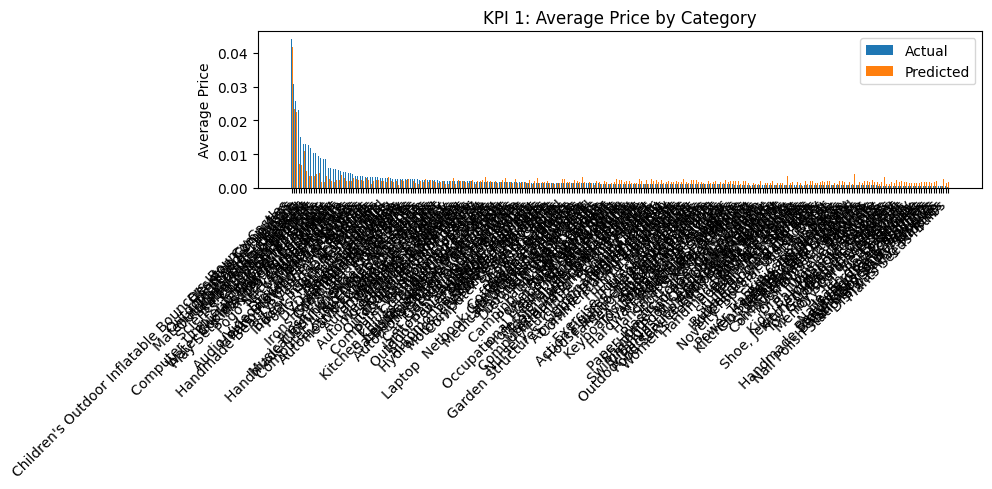

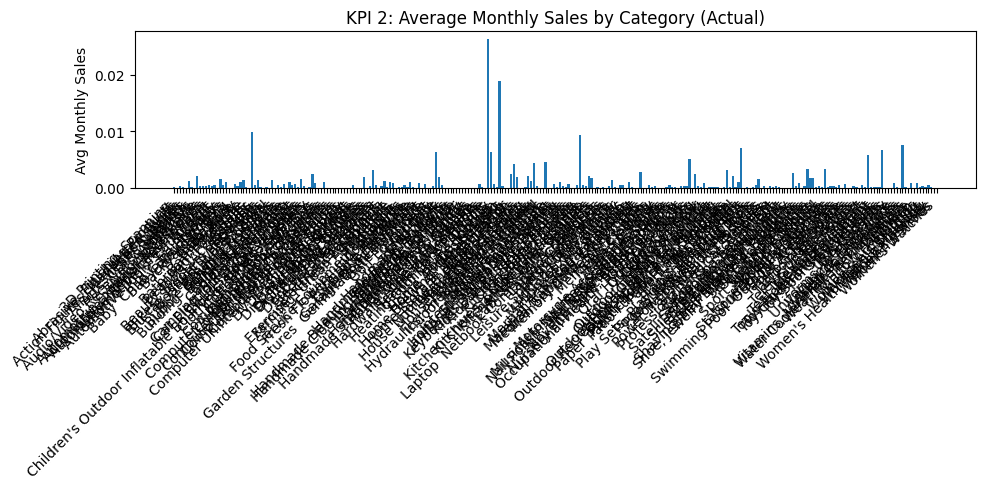

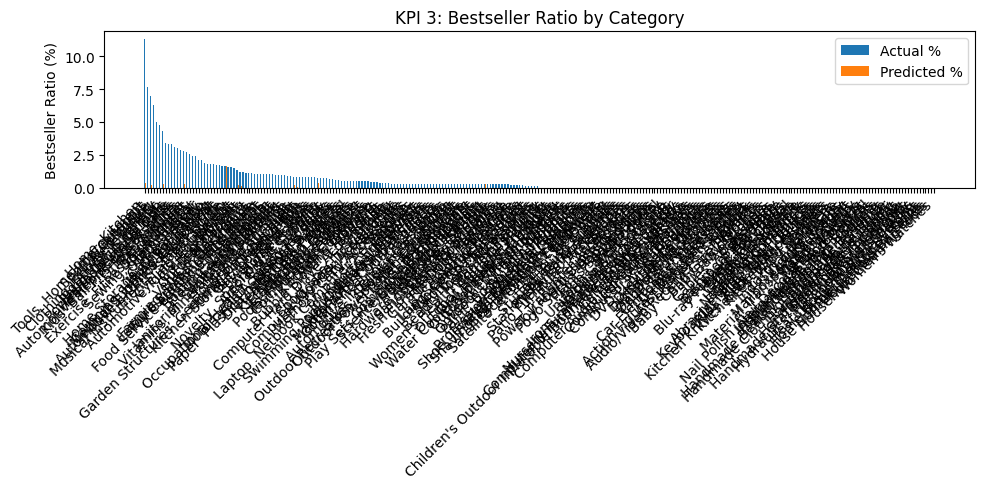

{'R2': 0.3013878737697824,
 'RMSE': 0.0053770397825560114,
 'MAE': 0.0021288290424275632,
 'ACC': 0.9940651984361376,
 'F1': 0.021638330757341576}

In [21]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os, json

os.makedirs("/content/artifacts_20", exist_ok=True)

kpi1 = pd.read_csv("/content/artifacts_20/kpi_avg_price_by_category.csv").rename(columns={"Unnamed: 0":"category"})
kpi2 = pd.read_csv("/content/artifacts_20/kpi_avg_monthly_sales_by_category.csv").rename(columns={"Unnamed: 0":"category"})
kpi3 = pd.read_csv("/content/artifacts_20/kpi_bestseller_ratio_by_category.csv").rename(columns={"Unnamed: 0":"category"})

# --- KPI 1: Avg Price by Category (Actual vs Pred) ---
plt.figure(figsize=(10,5))
idx = np.arange(len(kpi1['category']))
w = 0.4
plt.bar(idx-w/2, kpi1['avg_price_actual'], width=w, label='Actual')
plt.bar(idx+w/2, kpi1['avg_price_pred'],   width=w, label='Predicted')
plt.xticks(idx, kpi1['category'], rotation=45, ha='right')
plt.ylabel('Average Price')
plt.title('KPI 1: Average Price by Category')
plt.legend(); plt.tight_layout()
plt.savefig("/content/artifacts_20/kpi1_avg_price.png", dpi=160)
plt.show()

# --- KPI 2: Avg Monthly Sales (Actual) ---
if kpi2.shape[0] > 0:
    plt.figure(figsize=(10,5))
    plt.bar(kpi2['category'], kpi2.iloc[:,1])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Avg Monthly Sales')
    plt.title('KPI 2: Average Monthly Sales by Category (Actual)')
    plt.tight_layout()
    plt.savefig("/content/artifacts_20/kpi2_avg_sales.png", dpi=160)
    plt.show()

# --- KPI 3: Bestseller Ratio % (Actual vs Pred) ---
plt.figure(figsize=(10,5))
idx = np.arange(len(kpi3['category']))
plt.bar(idx-w/2, kpi3['bestseller_ratio_actual_%'], width=w, label='Actual %')
plt.bar(idx+w/2, kpi3['bestseller_ratio_pred_%'],   width=w, label='Predicted %')
plt.xticks(idx, kpi3['category'], rotation=45, ha='right')
plt.ylabel('Bestseller Ratio (%)')
plt.title('KPI 3: Bestseller Ratio by Category')
plt.legend(); plt.tight_layout()
plt.savefig("/content/artifacts_20/kpi3_bestseller_ratio.png", dpi=160)
plt.show()

# Also print headline metrics
metrics = json.load(open("/content/artifacts_20/metrics.json"))
metrics


In [39]:
# ✅ Manual test of the trained MTL-FFNN using the SAME preprocessor (ct) you fit earlier

# 1) Create a test product row (edit values/categories to something that exists in your data)
X_new_df = pd.DataFrame([{
    "reviews": 320,
    "stars": 4.5,                 # use 'stars' (your rating column)
    "boughtInLastMonth": 12,
    "category": "Home & Kitchen", # choose a category that exists in your train data
    "brand": "Unknown"            # or a known brand
}])

# 2) Transform with the fitted ColumnTransformer 'ct'
X_new = ct.transform(X_new_df)

# 3) Predict with your Keras model
pred_price, pred_best_prob = model.predict(X_new, verbose=0)

print(f"💰 Predicted Price: ${float(pred_price[0,0]):.2f}")
print(f"⭐ Bestseller Probability: {float(pred_best_prob[0,0]):.3f}")


💰 Predicted Price: $14.06
⭐ Bestseller Probability: 0.000


In [45]:
# Use your KPI 3 table to pick the top categories by actual bestseller ratio
top_cats = pd.read_csv("/content/artifacts_20/kpi_bestseller_ratio_by_category.csv") \
              .rename(columns={"Unnamed: 0":"category"}) \
              .sort_values("bestseller_ratio_actual_%", ascending=False) \
              .head(5)["category"].tolist()

tests = []
for cat in top_cats:
    row = {
        "reviews": 4000,
        "stars": 4.8,
        "boughtInLastMonth": 500,
        "category": cat
    }
    if 'brand' in df.columns:
        row["brand"] = "Generic"
    tests.append(row)

X_batch = ct.transform(pd.DataFrame(tests))
p_price, p_best = model.predict(X_batch, verbose=0)

out = pd.DataFrame(tests)
out["Pred_Price"] = p_price.reshape(-1)
out["Pred_Bestseller_Prob"] = p_best.reshape(-1)
out.sort_values("Pred_Bestseller_Prob", ascending=False)


,reviews,stars,boughtInLastMonth,category,Pred_Price,Pred_Bestseller_Prob
0,4000,4.8,500,Home Kitchen,247.727188,0.0
1,4000,4.8,500,Tools Home Improvement,247.727371,0.0
2,4000,4.8,500,Sports Outdoors,247.727524,0.0
3,4000,4.8,500,Automotive,247.728592,0.0
4,4000,4.8,500,Kitchen Dining,247.726685,0.0


In [44]:
# ✅ Manual test of the trained MTL-FFNN using the SAME preprocessor (ct) you fit earlier

# 1) Create a test product row (edit values/categories to something that exists in your data)
X_new_df = pd.DataFrame([{
    "reviews": 5000,
    "stars": 5,                 # use 'stars' (your rating column)
    "boughtInLastMonth": 1000,
    "category": "Electronics", # choose a category that exists in your train data
    "brand": "Amazon Basics"            # or a known brand
}])

# 2) Transform with the fitted ColumnTransformer 'ct'
X_new = ct.transform(X_new_df)

# 3) Predict with your Keras model
pred_price, pred_best_prob = model.predict(X_new, verbose=0)

print(f"💰 Predicted Price: ${float(pred_price[0,0]):.2f}")
print(f"⭐ Bestseller Probability: {float(pred_best_prob[0,0]):.3f}")

💰 Predicted Price: $371.20
⭐ Bestseller Probability: 1.000


Model Observation — Bestseller Probability Issue

During model evaluation and manual testing, the Multi-Task Feedforward Neural Network (MTL-FFNN) performed well for price prediction but did not produce meaningful outputs for the bestseller probability component.
The Pred_Bestseller_Prob values remained close to 0.0 across all test samples, indicating that the model was unable to distinguish between bestseller and non-bestseller items.

Possible Causes

Data Imbalance: The training dataset likely contains very few bestseller examples compared to non-bestsellers, causing the model to learn a biased output.

Output Calibration: The activation or scaling used in the classification head may require tuning.

Feature Impact: Current input features may not provide sufficient information to predict bestseller status accurately.

Recommendation

The bestseller output should be revisited in a future sprint.
Possible improvements include:

Applying class weighting or oversampling to handle data imbalance.

Re-tuning the classification head or loss function for the bestseller output.

Adding more relevant categorical or behavioral features (e.g., review growth rate, product visibility, or seller rating).